# Croston's method for forecasting intermittent demand

Use case: when a time series has many zero values.<br>
This is challenging for ARIMA-type models to deal<br>
with.

References:<br>
- [sktime docs](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.croston.Croston.html#sktime.forecasting.croston.Croston)  # noqa<br>
- [Blog post](https://towardsdatascience.com/croston-forecast-model-for-intermittent-demand-360287a17f5f)  # noqa<br>
- [Hyndman & Athanasopoulos, "Forecasting: Principles and Practice](https://otexts.com/fpp2/counts.html)  # noqa

Crostonâ€™s method will predict a constant value for<br>
all future times, so Crostonâ€™s method essentially<br>
provides another notion for the average value of a time series.

The method is (equivalent to) the following:<br>
- Let v_0 to v_n be the non-zero values of the time series<br>
- Let v be the exponentially smoothed average of v_0 to v_n<br>
- Let z_0 to z_n be the number of consecutive zeros plus 1 between the<br>
in the original time series.<br>
- Let z be the exponentially smoothed average of z_0 to z_n

Then the forecast at a particular time is: v/z

In [1]:
from sktime.forecasting.croston import Croston
from sktime.datasets import load_PBS_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all"

## Example 1: PBS dataset

In [3]:
y = load_PBS_dataset()

Text(0.5, 1.0, 'PBS dataset')

c:\Nayef\time-series-notes\.venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


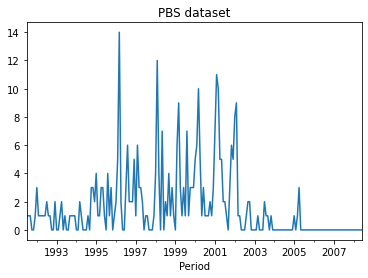

In [4]:
fig, ax = plt.subplots()
y.plot(ax=ax)
ax.set_title("PBS dataset")
fig.show()

In [5]:
forecaster = Croston(smoothing=0.1)
forecaster.fit(y)
y_pred = forecaster.predict(fh=[x for x in range(1, 11)])
y_pred.head()

Croston()

2008-07    0.868892
2008-08    0.868892
2008-09    0.868892
2008-10    0.868892
2008-11    0.868892
Freq: M, dtype: float64

The forcaster object retains the cutoff date:

In [6]:
forecaster.cutoff

Period('2008-06', 'M')

Combining actuals and fitted values:

In [7]:
y_actual_and_fitted = pd.DataFrame(
    {"y": y, "y_fitted": forecaster._f[1:]}, index=y.index
)

In [8]:
y_forecast = pd.concat([y_actual_and_fitted, y_pred])
y_forecast = y_forecast.rename(columns={0: "y_predicted"})

Text(0.5, 1.0, "Example 1 of forecast using Croston's method \nPharmaceutical Benefit Scheme univariate time series dataset")

c:\Nayef\time-series-notes\.venv\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


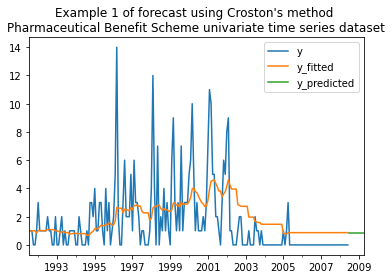

In [9]:
fig, ax = plt.subplots()
y_forecast.plot(ax=ax)
ax.set_title(
    "Example 1 of forecast using Croston's method \nPharmaceutical Benefit Scheme univariate time series dataset"  # noqa
)  # noqa
fig.show()

## Example 2

This is adapted from the sktime docs.

Here we can see that alpha values between 0 and 1.0 seem sensible.<br>
The larger the value of alpha, the more our fit weights recent<br>
data points.

In [10]:
y = pd.Series([0] * 30 + [2, 2, 0, 0, 0], name="series1")

Croston(smoothing=10)

35   -0.007435
36   -0.007435
37   -0.007435
38   -0.007435
39   -0.007435
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 10")

Croston(smoothing=1.5)

35   -0.142857
36   -0.142857
37   -0.142857
38   -0.142857
39   -0.142857
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 1.5")

Croston(smoothing=1)

35    2.0
36    2.0
37    2.0
38    2.0
39    2.0
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 1")

Croston(smoothing=0.5)

35    0.125
36    0.125
37    0.125
38    0.125
39    0.125
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 0.5")

Croston()

35    0.071429
36    0.071429
37    0.071429
38    0.071429
39    0.071429
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 0.1")

Croston(smoothing=0.01)

35    0.065147
36    0.065147
37    0.065147
38    0.065147
39    0.065147
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 0.01")

c:\Nayef\time-series-notes\.venv\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


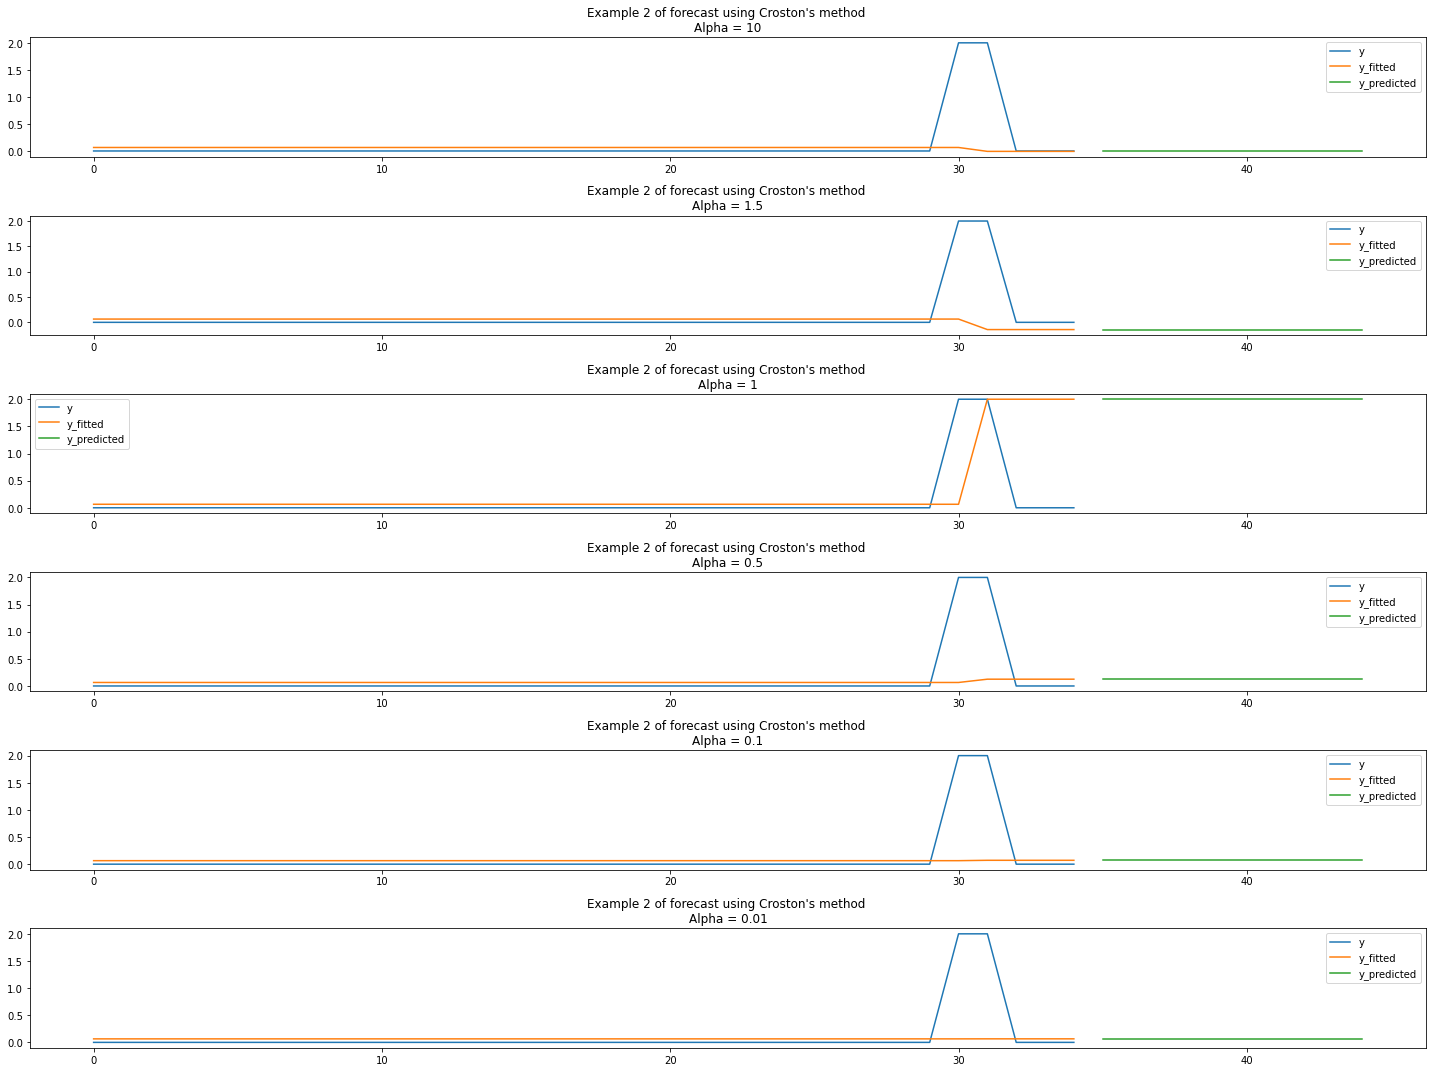

In [11]:
fig = plt.figure(figsize=(20, 15))
for n, smooth_value in enumerate([10, 1.5, 1, 0.5, 0.1, 0.01]):
    forecaster = Croston(smoothing=smooth_value)
    forecaster.fit(y)
    y_pred = forecaster.predict(fh=[x for x in range(1, 11)])
    y_pred.head()
    df_fitted = pd.DataFrame(
        {"y": y, "y_fitted": forecaster._f[1:]}, index=y.index
    )  # noqa
    df_pred = pd.concat([df_fitted, y_pred])
    df_pred = df_pred.rename(columns={0: "y_predicted"})
    ax = plt.subplot(6, 1, n + 1)
    df_pred.plot(ax=ax)
    ax.set_title(
        f"Example 2 of forecast using Croston's method \nAlpha = {smooth_value}"  # noqa
    )
fig.tight_layout()
fig.show()
# fig.savefig('dst/alpha-values.pdf')

## Example 3

This is a slight modification of Example 2, with fewer zero values.

In [12]:
y = pd.Series(
    [0] * 10
    + np.random.choice(a=[0, 1, 2], size=35, p=[0.5, 0.1, 0.4]).tolist()
    + [2, 2, 0, 0, 0],
    name="series1",
)

Croston(smoothing=10)

50   -0.010858
51   -0.010858
52   -0.010858
53   -0.010858
54   -0.010858
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 10")

Croston(smoothing=1.5)

50    2.585853
51    2.585853
52    2.585853
53    2.585853
54    2.585853
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 1.5")

Croston(smoothing=1)

50    2.0
51    2.0
52    2.0
53    2.0
54    2.0
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 1")

Croston(smoothing=0.5)

50    1.659682
51    1.659682
52    1.659682
53    1.659682
54    1.659682
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 0.5")

Croston()

50    0.62386
51    0.62386
52    0.62386
53    0.62386
54    0.62386
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 0.1")

Croston(smoothing=0.01)

50    0.193691
51    0.193691
52    0.193691
53    0.193691
54    0.193691
dtype: float64

Text(0.5, 1.0, "Example 2 of forecast using Croston's method \nAlpha = 0.01")

c:\Nayef\time-series-notes\.venv\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


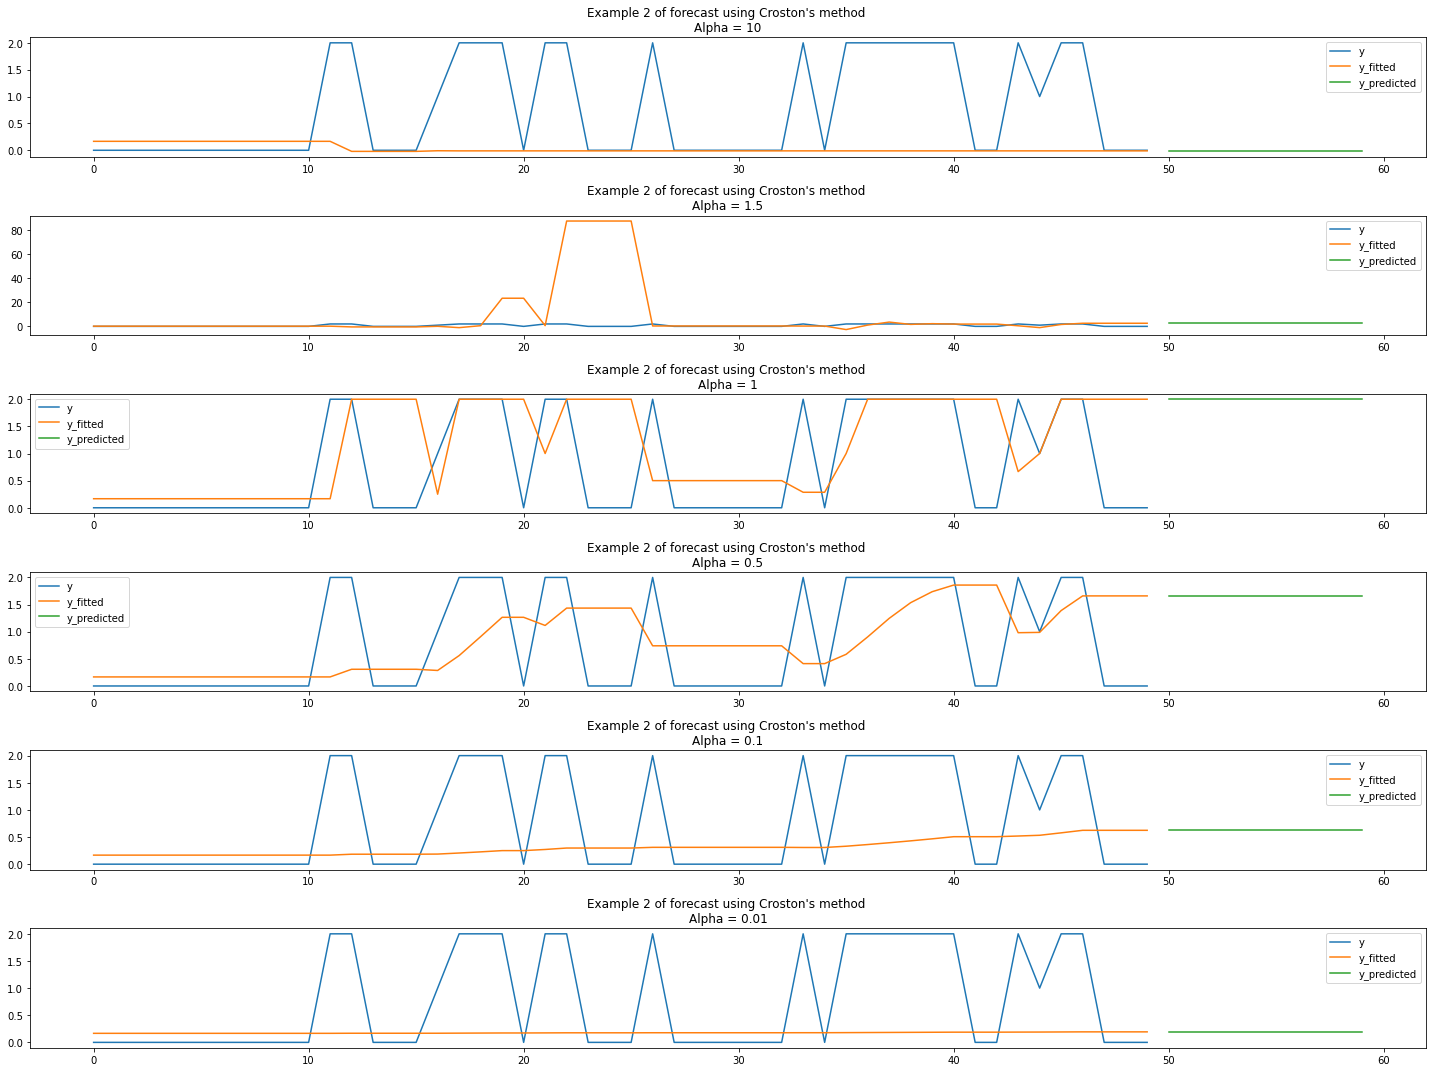

In [13]:
fig = plt.figure(figsize=(20, 15))
for n, smooth_value in enumerate([10, 1.5, 1, 0.5, 0.1, 0.01]):
    forecaster = Croston(smoothing=smooth_value)
    forecaster.fit(y)
    y_pred = forecaster.predict(fh=[x for x in range(1, 11)])
    y_pred.head()
    df_fitted = pd.DataFrame(
        {"y": y, "y_fitted": forecaster._f[1:]}, index=y.index
    )  # noqa
    df_pred = pd.concat([df_fitted, y_pred])
    df_pred = df_pred.rename(columns={0: "y_predicted"})
    ax = plt.subplot(6, 1, n + 1)
    df_pred.plot(ax=ax)
    ax.set_title(
        f"Example 2 of forecast using Croston's method \nAlpha = {smooth_value}"  # noqa
    )
    # ax.set_ylim(0, 10)
fig.tight_layout()
fig.show()
# fig.savefig('dst/alpha-values2.pdf')

## Example 4

Here we try to see how forecasts change as we spread out/cluster the<br>
positive values

In [14]:
y_not_clustered = pd.Series(
    [0, 1] + [0] * 3 + [1] + [0] * 3 + [1],
    name="y_not_clustered",
)

In [15]:
y_clustered = pd.Series(
    [0] * 7 + [1, 1, 1],
    name="y_clustered",
)

In [16]:
smooth_value = 0.1  # todo: try different smooth_values

Croston()

Text(0.5, 0.98, 'Hi')

Text(0.5, 1.0, "Example 4 of forecast using Croston's method \nAlpha = 0.1\n Series name = y_not_clustered")

(0.0, 3.0)

Croston()

Text(0.5, 0.98, 'Hi')

Text(0.5, 1.0, "Example 4 of forecast using Croston's method \nAlpha = 0.1\n Series name = y_clustered")

(0.0, 3.0)

c:\Nayef\time-series-notes\.venv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


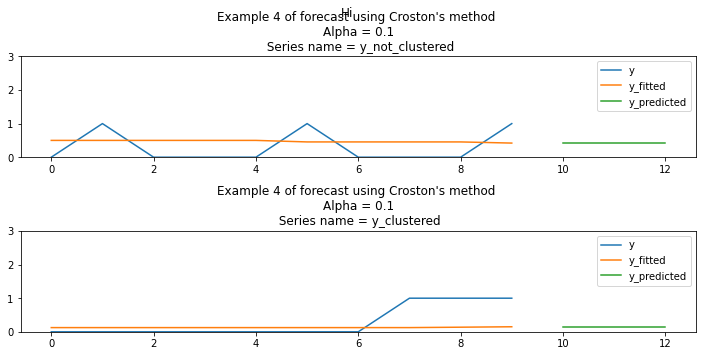

In [17]:
fig = plt.figure(figsize=(10, 5))
for n, y_series in enumerate([y_not_clustered, y_clustered]):
    forecaster = Croston(smoothing=smooth_value)
    forecaster.fit(y_series)
    y_pred = forecaster.predict(fh=[x for x in range(1, 4)])
    df_fitted = pd.DataFrame(
        {"y": y_series, "y_fitted": forecaster._f[1:]}, index=y_series.index
    )  # noqa
    df_pred = pd.concat([df_fitted, y_pred])
    df_pred = df_pred.rename(columns={0: "y_predicted"})
    plt.suptitle("Hi")
    ax = plt.subplot(2, 1, n + 1)
    df_pred.plot(ax=ax)
    ax.set_title(
        f"Example 4 of forecast using Croston's method \nAlpha = {smooth_value}\n Series name = {y_series.name}"  # noqa
    )
    ax.set_ylim(0, 3)
    plt.subplots_adjust(wspace=1, top=20)
fig.tight_layout()
fig.show()
# fig.savefig('clustered-vs-not-clustered.pdf')